# Speed dating data-set
## Discrimination-aware classification
#### <i>Abdel K. Bokharouss, Bart van Helvert, Joris Rombouts & Remco Surtel</i>   -   December 2017

<font color="darkred"><b><i>Important note: a concrete goal of this assignment is, among other things, to give an extensive and qualitative comparison between a model which includes sensitive attributes and a model which excludes these sensitive attributes. Whether or not attributes are considered to be sensitive is subjective, and any decisions should, therefore, be supported by well-grounded arguments.</i></b>
<br>
<b><i>This brings us to our next important point: This assignment was discussed during the instruction of Wednesday 29-11. The conclusion was made that the models of our first assignment used no significant amount of sensitive attributes (this was no requirement of the first assignment) to facilitate a qualitative comparison. In consultation with the instructors present during that instruction, the choice was made to re-make the same model which was used in assignment 1, but with more sensitive attributes. This will facilitate a better comparison with the discrimination-aware model which uses no sensitive attributes</i></b></font>

### <font color="green">Imports, preparation and configuration</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing, metrics
import matplotlib.pyplot as plt
import io
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# imports needed for the visualization and exportation of visualizations
import graphviz as gv # not included in the standard anaconda installer (can be found in the Anaconda Navigator)
import pydotplus # not included in anaconda at all (use pip/conda install pydotplus in cmd/conda prompt etc)
import io
from scipy import misc

In [3]:
from IPython.core.display import HTML # markdown cell styling and enabling/disabling warning messages
HTML("""
<style>
div.text_cell_render h1 {
font-size: 1.6em;
line-height:1.2em;
}

div.text_cell_render h2 { 
margin-bottom: -0.4em;
}

div.text_cell_render { 
font-size:1.2em;
line-height:1.2em;
font-weight:500;
}

div.text_cell_render p, li {
color:Navy;
}

</style>

<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.
""") 

In [4]:
np.random.seed(44) # seed the generator

The previous model used the following attributes:
* <b>order</b>
* <b>field</b>
* <b>imprace</b> and <b>imprelig</b>
* <b>goal</b>, <b>date</b> and <b>go_out</b>

And in 1.3 the following attributes were "engineered" from existing attributes:
* <b>age_diff</b>: The absolute difference between the subject's age and the partner's age.
* <b>attr_o</b>: Rating by partner the night of the event, for all six attributes (attr, sinc, intel, fun, amb, and shar).
* <b>race_equals</b>: Boolean value, which is True if the race of the partner is the same as the race of the participant, and False otherwise.
* <b>goal_equals</b>: Boolean value, which is True if the goal of the partner is the same as the goal of the participant, and False otherwise.

<font color="darkred">The attributes <b>imprace</b>, <b>imprelig</b>, <b>age_diff</b> and <b>race_equals</b> are considered to be sensitive attributes.</font>

<font color="darkred">The choice was made to feed the model one more sensitive attribute: <b>race</b>. Another attribute that was considered sensitive is the <b>income</b> attribute. However, this attribute has a lot of missing values. Which is why the choice was made to exclude it from the model. In addition to adding one sensitive attribute to the model, the goal of re-making the model is to decrease the <b>height</b> of the decision tree. The height of the decision trees in the first assignment was chosen to be eight. A tree with a lower height would ease the visualization and evaluation process. The height is going to be decreased in steps while checking the performance of the models. The goal is to find the right trade-off between the height and the performance of the model.</font>

<font color="darkred">Considering the fact that the second assignment states that model can be potentially used to match partcipants of a (speed) dating event beforehand, it does not make sense anymore to use the <b>attr_o</b> attribute, since this is a rating which is given after a date. The choices is, therefore, to change this attribute into just the <b>attr</b> attribute (unlike attributes such as the rating of, for example, someone's intelligence) (one of the 6 dimensions of the attr_o attribute). The attractiveness could be rated before a date, for example by showing pictures of potential dates. This is, of course, controversial and can thus immediately be considered as a sensitive attribute.</font>

### <font color="green">Gender models with sensitive attributes</font>

In [5]:
dates = pd.read_csv("speed_dating_assignment.csv")
dates.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


The next few cells are for preprocessing purposes (filtering, construction of new attributes etc.).

In [6]:
dates_new = dates.copy()
dates_new = dates_new.filter(items = ['iid', 'age', 'race', 'goal'])
dates_new.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
dates_new = dates_new.drop_duplicates()
dates_new_merge = pd.merge(dates, dates_new, on=['pid'], how = 'left')
dates = dates_new_merge.copy()

In [7]:
dates = dates[['attr', 'gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner', 'dec']]

In [8]:
dates.age.fillna(dates.age.median(), inplace = True)
dates = dates.dropna().reset_index(drop = True)

#### <font color="green">Calculating new features</font>

<font color="red"><b><i>Explanations have been left out in this document. If one is interested in the explanation of the code and/or results, please consult our first assignment.</i></b>

In [9]:
dates['age_diff'] = abs(dates['age'] - dates['age_o'])

In [10]:
dates['race_equals'] = (dates['race'] == dates['race_partner'])

In [11]:
dates['goal_equals'] = dates.apply(lambda r: r.goal == r.goal_partner, axis = 1)

In [12]:
dates = dates[['gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace',  'imprelig', 'attr', 'race','age_diff', 'goal_equals', 'dec']]
dates.head()

,gender,order,goal,field_cd,date,age,go_out,imprace,imprelig,attr,race,age_diff,goal_equals,dec
0,0,4,2.0,1.0,7.0,21.0,1.0,2.0,4.0,6.0,4.0,6.0,False,1
1,0,3,2.0,1.0,7.0,21.0,1.0,2.0,4.0,7.0,4.0,1.0,False,1
2,0,10,2.0,1.0,7.0,21.0,1.0,2.0,4.0,5.0,4.0,1.0,True,1
3,0,5,2.0,1.0,7.0,21.0,1.0,2.0,4.0,7.0,4.0,2.0,True,1
4,0,7,2.0,1.0,7.0,21.0,1.0,2.0,4.0,5.0,4.0,3.0,False,1


In [13]:
male_subjects = dates[dates.gender == 1]
female_subjects = dates[dates.gender == 0]
male_subjects = male_subjects.drop('gender', axis = 1) # do not need this attribute
female_subjects = female_subjects.drop('gender', axis = 1) # do not need this attribute
male_subjects.shape, female_subjects.shape

((3957, 13), (4004, 13))

In [14]:
male_subjects_shuffle = male_subjects.sample(frac=1).reset_index(drop=True) # shuffle rows
female_subjects_shuffle = female_subjects.sample(frac=1).reset_index(drop=True)

In [15]:
male_x_data = male_subjects_shuffle.drop('dec', axis = 1) # dec is target attribute
female_x_data = female_subjects_shuffle.drop('dec', axis = 1)
male_labels = male_subjects_shuffle['dec']
female_labels = female_subjects_shuffle['dec']

In [16]:
male_x_train, male_x_test, male_y_train, male_y_test = train_test_split(male_x_data, male_labels, test_size = 0.2)
female_x_train, female_x_test, female_y_train, female_y_test = train_test_split(female_x_data, female_labels, test_size = 0.2)

In [17]:
dec_tree_male = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dec_tree_female = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
# build decision tree classifiers from the training sets
dec_tree_male.fit(male_x_train, male_y_train)
dec_tree_female.fit(female_x_train, female_y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
def visualize_tree(dec_tree, path, classnames, feat_names):
    dfile = io.StringIO()
    tree.export_graphviz(dec_tree, out_file = dfile, feature_names = feat_names)
    pydotplus.graph_from_dot_data(dfile.getvalue()).write_png(path)
    i = misc.imread(path)
    plt.imshow(i)

In [19]:
male_col_names = dec_tree_male.classes_
male_feature_names = male_subjects.columns[0:(male_subjects.shape[1] - 1)] # the features (attributes) used in the model
#visualize_tree(dec_tree_male, "male_decision_tree_sens.png", male_col_names, male_feature_names)

![title](male_decision_tree_sens.png)

In [20]:
female_col_names = dec_tree_female.classes_
female_feature_names = female_subjects.columns[0:(female_subjects.shape[1] - 1)] # the features (attributes) used in the model
#visualize_tree(dec_tree_female, "female_decision_tree_sens.png", female_col_names, female_feature_names)

![title](female_decision_tree_sens.png)

### <font color="green">Evaluating the performance of the gender models</font>

<font color="red"><b><i>Explanations have been left out in this document. If one is interested in the explanation of the code and/or results, please consult our first assignment.</i></b>

In [21]:
pred_male = dec_tree_male.predict(male_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(male_y_test, pred_male))

Accuracy score:  0.710858585859


In [22]:
pred_female = dec_tree_female.predict(female_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(female_y_test, pred_female))

Accuracy score:  0.715355805243


In [23]:
print(metrics.classification_report(male_y_test, pred_male))

             precision    recall  f1-score   support

          0       0.71      0.72      0.71       395
          1       0.71      0.71      0.71       397

avg / total       0.71      0.71      0.71       792



In [24]:
print('percentage "dec = 0" in the male data set: ', round((male_subjects_shuffle.loc[male_subjects_shuffle.dec == 0].shape[0] / male_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the male data set: ', round((male_subjects_shuffle.loc[male_subjects_shuffle.dec == 1].shape[0] / male_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")

percentage "dec = 0" in the male data set:  51.18 %
percentage "dec = 1" in the male data set:  48.82 %


In [25]:
print(metrics.classification_report(female_y_test, pred_female))

             precision    recall  f1-score   support

          0       0.74      0.83      0.78       501
          1       0.65      0.52      0.58       300

avg / total       0.71      0.72      0.71       801



In [26]:
print('percentage "dec = 0" in the female data set: ', round((female_subjects_shuffle.loc[female_subjects_shuffle.dec == 0].shape[0] / female_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the female data set: ', round((female_subjects_shuffle.loc[female_subjects_shuffle.dec == 1].shape[0] / female_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")

percentage "dec = 0" in the female data set:  62.74 %
percentage "dec = 1" in the female data set:  37.26 %


### <font color="green">Unisex model with sensitive attributes</font>

In [27]:
unisex = pd.read_csv("speed_dating_assignment.csv")

In [28]:
unisex_o = unisex.copy()
unisex_o = unisex_o.filter(items=['iid', 'age', 'race', 'goal'])
unisex_o.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
unisex_o = unisex_o.drop_duplicates()

unisex_new = pd.merge(unisex, unisex_o, on=['pid'], how = 'left')
unisex = unisex_new.copy()

In [29]:
unisex = unisex[['attr', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner']]
unisex.age.fillna(unisex.age.median(), inplace = True)
unisex = unisex.dropna().reset_index(drop=True)

### <font color="green">Calculating new features</font>

In [30]:
unisex['age_diff'] = abs(unisex['age'] - unisex['age_o'])
unisex['race_equals'] = (unisex['race'] == unisex['race_partner'])
unisex['goal_equals'] = unisex.apply(lambda r: r.goal == r.goal_partner, axis = 1)
unisex = unisex[['order','goal', 'field_cd', 'date','age', 'go_out', 'attr', 'imprace', 'imprelig', 'race','age_diff', 'goal_equals', 'dec']]
unisex.head()

,order,goal,field_cd,date,age,go_out,attr,imprace,imprelig,race,age_diff,goal_equals,dec
0,4,2.0,1.0,7.0,21.0,1.0,6.0,2.0,4.0,4.0,6.0,False,1
1,3,2.0,1.0,7.0,21.0,1.0,7.0,2.0,4.0,4.0,1.0,False,1
2,10,2.0,1.0,7.0,21.0,1.0,5.0,2.0,4.0,4.0,1.0,True,1
3,5,2.0,1.0,7.0,21.0,1.0,7.0,2.0,4.0,4.0,2.0,True,1
4,7,2.0,1.0,7.0,21.0,1.0,5.0,2.0,4.0,4.0,3.0,False,1


In [31]:
# Training the model
subjects_shuff_uni = unisex.sample(frac=1).reset_index(drop=True) # shuffle rows
x_data_uni = subjects_shuff_uni.drop('dec', axis = 1) # dec is target attribute
labels_uni = subjects_shuff_uni['dec']

In [32]:
x_train_uni, x_test_uni, y_train_uni, y_test_uni = train_test_split(x_data_uni, labels_uni, test_size = 0.2)

In [33]:
dec_tree_uni = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dec_tree_uni.fit(x_train_uni, y_train_uni)
col_names_uni = dec_tree_uni.classes_
feature_names_uni = unisex.columns[0:(unisex.shape[1] - 1)] # the features (attributes) used in the model
#visualize_tree(dec_tree_uni, "unisex_decision_tree_sens.png", col_names_uni, feature_names_uni)

![title](unisex_decision_tree_sens.png)

In [34]:
pred_uni = dec_tree_uni.predict(x_test_uni) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(y_test_uni, pred_uni))

Accuracy score:  0.747018204645


In [35]:
print(metrics.classification_report(y_test_uni, pred_uni))

             precision    recall  f1-score   support

          0       0.78      0.76      0.77       896
          1       0.70      0.73      0.72       697

avg / total       0.75      0.75      0.75      1593



In [36]:
print('percentage "dec = 0" in the unisex data set: ', round((subjects_shuff_uni.loc[subjects_shuff_uni.dec == 0].shape[0] / subjects_shuff_uni.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the unisex data set: ', round((subjects_shuff_uni.loc[subjects_shuff_uni.dec == 1].shape[0] / subjects_shuff_uni.dec.values.shape[0]) * 100, 2), "%")

percentage "dec = 0" in the unisex data set:  56.99 %
percentage "dec = 1" in the unisex data set:  43.01 %


## <font color="red">----------------------------------------------------------------------------------------------------</font>

## <font color="red">Start second homework assignment</font>

# Part 2: Discrimination-aware classification

#### <font color="darkred">The goal of this assignment is to acquire a deeper understanding of model performance and to study how one can compare the performance of different models and their internals/decision logic.</font>

## 1 Sensitive attributes in classification

### 1.1 Modeling without sensitive attributes

The predictive models of the first assignment can be used to match partcipants of a (speed) dating event, for example. Some people might not like the idea of an algorithm matching them to other participants, though. This is especially true when this algorithm uses sensitive (<i>subjective</i>) attributes about them, such as their race, age (difference), how they value religion in their lives, et cetera.

<br>The models which were trained in the first assignment (<b>see the two gender- and unisex model(s) at the start of this notebook</b>) did use some attributes that would be considered sensitive attributes. In particular, these models used the attributes <i>imprace</i>, <i>imprelig</i>, <i>race_equals</i>, <i>age_diff</i>, and <i>race</i>.
The first two attributes tell us something about how the subject values a partner who is of the same racial/religious background. The third attribute tells us whether the subject and potential match have the same racial background. The fourth attribute tells us about the age difference between the subject and the potential match. And the last attribute is the race of the subject. These are all considered to be sensitive attributes. It should come as no surprise that attributes related to the ethnicity and/or religious background are considered to be sensitive. Take for example the commotion last week around Facebook using the ethnicity of its users to target ads (https://www.technologyreview.com/the-download/609543/facebook-still-lets-people-target-ads-by-race-and-ethnicity/). The age difference is also considered to be a sensitive attribute, since a lot of people would not like to be restricted to certain matches because of their age.

Therefore, the first step of this task is to build a predictive model that does not include these attributes.

In [37]:
attr_used_old = ['order','goal', 'field_cd', 'date','age', 'go_out', 'imprace',
                 'imprelig', 'race','age_diff', 'attr', 'goal_equals', 'dec'] # old attributes used
sensitive_attr = ['imprace', 'imprelig', 'race_equals', 'age_diff', 'race', 'age'] # attributes which should be excluded
without_sens = [attribute for attribute in attr_used_old if attribute not in sensitive_attr]

In [38]:
uni_sens = unisex[without_sens] # use the same attributes, but exclude the sensitive attributes
print(uni_sens.shape)
uni_sens.head()

(7961, 8)


,order,goal,field_cd,date,go_out,attr,goal_equals,dec
0,4,2.0,1.0,7.0,1.0,6.0,False,1
1,3,2.0,1.0,7.0,1.0,7.0,False,1
2,10,2.0,1.0,7.0,1.0,5.0,True,1
3,5,2.0,1.0,7.0,1.0,7.0,True,1
4,7,2.0,1.0,7.0,1.0,5.0,False,1


In [39]:
uni_sens_shuff = uni_sens.sample(frac = 1).reset_index(drop = True) # shuffle the data
x_data_uni_sens = uni_sens_shuff.drop('dec', axis = 1) # dec is target attribute
labels_uni_sens = uni_sens_shuff['dec']

We use an 80/20 training-test split, since this ratio was also used in the previous model.

In [40]:
x_train_uni_sens, x_test_uni_sens, y_train_uni_sens, y_test_uni_sens = train_test_split(
    x_data_uni_sens, labels_uni_sens, test_size = 0.2)

The max-depth is set to 3, which will ease the comparative research between the model exploiting sensitive attributes and this model, which is the same model except it excludes the sensitive attributes in the training and classification.

In [41]:
dec_tree_uni_sens = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dec_tree_uni_sens.fit(x_train_uni_sens, y_train_uni_sens)
col_names_uni_sens = dec_tree_uni_sens.classes_
feature_names_uni_sens = uni_sens.columns[0:(uni_sens.shape[1] - 1)] # the features (attributes) used in the model
#visualize_tree(dec_tree_uni_sens, "unisex_decision_tree_noSensAttr.png", col_names_uni_sens, feature_names_uni_sens)

![title](unisex_decision_tree_noSensAttr.png)

In [42]:
pred_uni_sens = dec_tree_uni_sens.predict(x_test_uni_sens) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(y_test_uni_sens, pred_uni_sens))

Accuracy score:  0.740740740741


In [43]:
print(metrics.classification_report(y_test_uni_sens, pred_uni_sens))

             precision    recall  f1-score   support

          0       0.77      0.75      0.76       883
          1       0.70      0.72      0.71       710

avg / total       0.74      0.74      0.74      1593



#### <font color="green">Evaluating the performance of the (same) model which excludes the sensitive attributes</font>

A few cells back one can see that the accuracy of the same unisex model <i>(0.747)</i> using the sensitive attributes is only slightly better than the accuracy of the same unisex model which exludes these attributes from the classification process. In the first assignment, we have seen that accuruacy may not be the most appropriate performance metric, depending on the situation. Thus, the insignificant difference in accuracy does not necessarily validate a conclusion about the difference in performance between the two models. Therefore, the next step is to look at the other performance metrics. 

Even though the expectation is that there will be no major differences in precision and recall between the models, one can see that the recall of the model with the sensitive attributes for the cases in which the subject expressed an interest in his/her partner after the date (<i>dec = 1</i>) is higher than the recall of the same type of cases for the model excluding sensitive attributes, but this difference of 0.01 is, of course, not significant. The precision for this case remained the same after the exclusion of the sensitive attributes. The recall and precision metrics for the other potential value of the target attribute also didn't undergo major devaluations. Both the recall and precision dropped by 0.01. Therefore, one could argue that the model got slightly worse at recognizing these cases (dec = 0) without the sensitive attributes, even though these differences are not substantial by any means. The slight drop in these performance metrics explains the slight decrease of the accuracy of the model which excludes the sensitive attributes.

#### <font color="green">Comparing the models in terms of discrimination</font>

Several metrics which can be used to measure discrimination have been explained in a paper on the topic of discrimination/fairness-aware data mining (<a>link.springer.com/article/10.1007/s10618-017-0506-1</a>). The next step is to choose one or more of these discrimination measures to be able to quantify whether the model(s) discriminate, and if they do, how much they disciminate.

Before diving into the actual discrimination measures, some notation needs to be introduced. Fair/non-discriminating data-minining can be defined as:
1. People who are similar in terms of non-protected charactersitics (i.e. non-sensitive atttributes) should receive similar predictions (i.e. classifications).
2. Differences in predictions across groups of people can only be as large as justified by their non-protected (ie. non-sensitive attributes).

If this is translated to problem domain of matching subjects at a dating event, the following conditions should hold in the context of fair/non-discriminating data-mining in predicitve models exploited at these events:

1. Subjects who have similar non-sensitive attributes (all the attributes used in the model, excluding the attributes which were classified earlier on as sensitive) should receive similar predictions.
2. Differences in predictions across groups of subjects can only be as large as justified by their non-sensitive attributes.

The first condition is necessary, but not suffcient by itself to ensure non-discrimination/fairness in the predictive models. This can be explained by the fact that even though subjects who are similar (as far as the non-sensitve attributes can tell) are treated similary (receive similar predictions), groups of subjects with similarities in the non-sensitive attributes may be treated differently from other groups of subjects. 

Now let's get into the actual discrimination measures. The variable $y$ is used to denote the value of a binary target variable, $y \in \{y^+, y^-\}$ ($+$ (1) and $-$ (0) are used to denote the potential values of the binary target attribute).

The variable $s$ will be used to denote a protected attribute (i.e. a sensitive attribute) and $s^i$ will be used to denote the value of a categorical/binary protected attribute (i.e. a sensitive attribute). Index 1 will be used to denote the protected group in the context of this variable (e.g. $s^1$ will be used to denote a potential ethnic minority, and $s^0$ the majority).

The following probability notations will be used: $p(s^1)$ for $p(s = 1)$ and $p(y^+)$ for $p(y = +)$.

Various discrimination measure types are given in the paper (e.g staticitcal tests, absolute-, conditional-, and situation-measures). Not all of these types are going to be considered in this discrimination analysis ( $\geq 1$ measure has to be assessed). The focus is going to be on absolute measures.

Absolute measures measure the magnitude of discrimination (and thus also the presence/absence of discrimination). The groups are described by a certain characteristic protected attribute. In other words, the groups are divided by a certain sensitive attribute. This can be done with two groups (e.g. if gender would be considered to be a sensitive attribute; males and females), but also with more than one group (e.g. ethnicities). In the latter case, one typically compares all the groups  to the most favoured group.

An absolute measure of discriminiation is the <b>mean difference</b> $d$. It is given by: $d = E(y^+\,|\, s^0) - E(y^+\,|\,s^1)$. If there is no difference, then it is concluded that there is no discrimination. Note that there is, however, no correction for the standard deviation.

The most obvious sensitive attribute which is considered in this analysis to which this absolute measure can be applied, is the <i>race</i> attribute. The ethnicities found in the test split of the unisex model, which uses the sensitive attributes (and thus the race attribute), are:

In [44]:
unisex.race.unique()

array([ 4.,  2.,  6.,  3.,  1.])

The speed-dating datasets uses numerical encodings to distinguish the different races
* 1 = Black/African American
* 2 = European/Caucasian-American
* 3 = Latino/Hispanic American
* 4 = Asian/Pacific Islander/Asian-American
* <font color="lightgrey">(5 = Native America) </font> 
* 6 = Other

Let's consider the mean of the binary target attribute of each of these ethnic groups (in the test sample).

In [45]:
race_encodings = {"Black/African American": 1, "European/Caucasian-American": 2, "Latino/Hispanic American": 3, 
                   "Asian/Pacific Islander/Asian-American": 4, "Other": 6}

The test sample can be found under the variable $x\_test\_uni$. This dataframe does not have a column with the actual predictions for those records. The actual predictions can be found under the variable $pred\_uni$. These two need to be linked before the mean of the binary target attribute of each of the ethnic groups can be calculated.

In [46]:
x_data_test = x_test_uni.copy()
x_data_test["pred_dec"] = pred_uni # assign the prediction to the original test records
x_data_test.head() 

,order,goal,field_cd,date,age,go_out,attr,imprace,imprelig,race,age_diff,goal_equals,pred_dec
3108,5,2.0,13.0,6.0,29.0,3.0,5.0,2.0,7.0,2.0,1.0,False,0
4691,7,1.0,3.0,6.0,27.0,3.0,4.0,3.0,5.0,2.0,1.0,True,0
3591,3,5.0,5.0,5.0,22.0,3.0,4.0,6.0,6.0,2.0,6.0,False,0
6782,5,3.0,1.0,6.0,24.0,1.0,7.0,1.0,3.0,4.0,3.0,False,1
7732,1,1.0,3.0,4.0,33.0,2.0,7.0,1.0,7.0,2.0,6.0,False,1


In [47]:
for k, v in race_encodings.items():
    print("The mean of the target attribute of the", k, "group is", x_data_test.loc[x_data_test.race == v].pred_dec.mean())

The mean of the target attribute of the Black/African American group is 0.5052631578947369
The mean of the target attribute of the European/Caucasian-American group is 0.4638009049773756
The mean of the target attribute of the Latino/Hispanic American group is 0.43333333333333335
The mean of the target attribute of the Asian/Pacific Islander/Asian-American group is 0.40934065934065933
The mean of the target attribute of the Other group is 0.52


One can immediately conclude that the model which uses the sensitive attributes ($race$ in particular) is not an example of fair/non-discriminating data-minining/predictive modeling. The magnitude of discrimination for all the groups can be calculated by $d = E(y^+\,|\, s^0) - E(y^+\,|\,s^1)$, where one uses the ethnic minority as $s^1$, which is in this case the Asian/Pacific Islander/Asian-American group, and where $s^0$ would be the majority. Calculating the magnitude of discrimination for the Asian/Pacific Islander/Asian-American would result in $d = E(y^+\,|\, s^0) - E(y^+\,|\,s^1) = E(y^+\,|\, s^0) - 0.40934.$

Note, however, that the absolute measure mean difference should actually be used for binary protected variables. The mean difference should thus be defined as the mean targets of the protected group and the general group. This means that one ethnic group should be classified as the protected group, while all the other ethnic groups (i.e. races) are defined to be the general group in this problem's context  This immediately brings us to the next question: based on the results depicted above, what group should be classified as the protected group and the general group? This can be a tricky question since it depends on the context of the problem and the perspective of the problem-solver. First note that discrimination by a predictive model can only occur when the target variable is polar. In the paper on discrimination measures a classical and straightforward example is given. The paper discusses the problem of loan-granting. It is quite clear that getting a loan (for which is applied by the applicant) is better than receiving no loan, when this decision making is done or supported by an algorithm (predictive model). It is thus quite clear that when a protected group which is shown to receive loans less often than a similar group with the same attributes, except the sensitive attributes, there is discrimination. But in the context of speed-dating one could argue both ways. One could say that an algorithm which matches the subject less often is better than when it matches the subject more often (i.e. the mean of the target-attribute <i>dec</i> is lower) since this would mean that the subject has to go on fewer dates with potential partners (more effective), if this model is used to match subjects before actually sending them out on dates. But one could also argue that a match prediction outcome (dec = 1) is superior to others (dec = 0). We chose the latter, since the assumption is made that subjects would probably rather go on more dates and increase their chances of finding a partner. Thus, this means a lower mean of the target attribute would be considered to be unfavourable compared to a higher mean of the target attribute.

Thus, this would imply that the Asian/Pacific Islander/Asian-American group is the ethnic minority in this context and that the absolute mean of the majority (general group) would be the mean of all the ethnic groups other than the Asian/Pacific Islander/Asian-American group. 

In [48]:
print("The mean of the target attribute of the majority (general group) = ",
      x_data_test.loc[x_data_test.race != race_encodings.get("Asian/Pacific Islander/Asian-American")].pred_dec.mean())

The mean of the target attribute of the majority (general group) =  0.467860048820179


So, the magnitude of discrimination for the Asian/Pacific Islander/Asian-American would result in $d = E(y^+\,|\, s^0) - E(y^+\,|\,s^1) = 0.46786 - 0.40934 = 0.05852 $

From this calculation one can safely conclude the presence of discrimination of the predictive model at a dataset level. In addition, the magnitude of this discrimination for the ethnic minortity which is the Asian/Pacific Islander/Asian-American is captured. Note how close the mean of the target attribute of the European/Caucasian-American group is to the mean of the of the target attribute of the majority (general group) (even though the European/Caucasian-American subjects are also used in the calculation of the man of the majority). One would expect that this group would be the least prone to discrimination at a speed-dating event in the United States, as one can conclude from these measures. It is, however, not safe to reason about any causation of the resulting measure, considering the small sample size and relative general and instable model.

Another absolute measure which will be considered (extra; one discrimination meausure is ought to be sufficient according to the assignment description) is the normalized difference. The normalized difference is fairly similar to the absolute mean difference, except as one would expect from the name of the measure; the mean difference is normalized by the rate of the positive outcomes. This can be captured by the following formula (where $\delta$ denotes the normalized mean difference):

$\delta = \frac{p\left(y^+\,|\, s^0\right) - p\left(y^+\,|\,s^1\right)}{d_{max}}$, $\, \,$where $\, d_{max} = min\,\left(\left(\frac{ p(y^+)}{p(s^1)}\right),\left(\frac{p(y^-)}{p(s^0)}\right)\right)$

Now let's calculate $d_{max}$ first.

In [49]:
p_y_plus = len(x_data_test[x_data_test.pred_dec == 1]) / len(x_data_test)
p_y_min = len(x_data_test[x_data_test.pred_dec == 0]) / len(x_data_test) # can also use 1 - p_y_plus
"p_y_plus: ", p_y_plus, "p_y_min: ", p_y_min, (p_y_plus +  p_y_min == 1)

('p_y_plus: ', 0.45448838669177655, 'p_y_min: ', 0.5455116133082235, True)

In [50]:
p_s_one = p_y_plus = len(x_data_test[x_data_test.race == 
                                     race_encodings.get("Asian/Pacific Islander/Asian-American")]) / len(x_data_test)
p_s_zero = len(x_data_test[x_data_test.race
                           != race_encodings.get("Asian/Pacific Islander/Asian-American")]) / len(x_data_test)
"p_s_one: ", p_s_one, "p_s_zero: ", p_s_zero, (p_s_one +  p_s_zero == 1)

('p_s_one: ', 0.22849968612680477, 'p_s_zero: ', 0.7715003138731952, True)

In [51]:
d_max = min((p_y_plus / p_s_one), (p_y_min / p_s_zero))
d_max

0.7070789259560619

In [52]:
numerator = (x_data_test.loc[x_data_test.race != race_encodings.get(
    "Asian/Pacific Islander/Asian-American")].pred_dec.mean()) - (x_data_test.loc[x_data_test.race == race_encodings.get(
    "Asian/Pacific Islander/Asian-American")].pred_dec.mean())
numerator

0.05851938947951968

In [53]:
normalized_difference = (numerator) / d_max
normalized_difference

0.08276217453432644

This measure takes into account maximum possible discrimination at a given positive outcome rate, such that the magnitude of discrimination is at most $\delta = 1$ (maximum possible discrimination), while $\delta = 0$ indicates the absence of discrimination, as explained in the paper on measuring discrimination in algorithmic decision making. From these results one  can conclude that there is indeed some discrimination present in the predictive model on data set level, but the discrimination is far from extreme. Additionally, note that more protected attributes (i.e. sensitive attributes) can be evaluated to get a more complete assessment of discrimination in the model.

### 1.2 Qualitative Comparison

Two unisex models have been considered in part 1.1. One model that includes-, and one model that excludes these same sensitive attributes. The performance differences, absence/presence of discrimination and magnitude of discrimination have been assessed and evaluated. The next step is to look for differences in behaviour (i.e. decision) logic between the two models.

This comparison is going to start with a comparison of the visualizations which capture the decision logic of the two models that respectively include and exclude the sensitive attributes.

These two walks in the decision trees are a clear difference in decision logic of the two models:

* $(attr \leq 6.25) \,\rightarrow\, (attr > 5.5)\, \rightarrow\, (go\_out > 5.5)$ $\rightarrow$ ($dec = 1$) for the model which excludes sensitive attributes.
* $(attr \leq 6.25) \,\rightarrow\, (attr > 4.5)\, \rightarrow\, (attr > 5.5)$ $\rightarrow$ (i.e. $dec = 0$) for the model which includes sensitive attributes.

Let's have a look whether the predictions for the test sample are conforming to this analysis of the differences in the decision logic.

In [54]:
x_data_nosens_test = x_test_uni_sens.copy()
x_data_nosens_test["pred_dec"] = pred_uni_sens  # assign the prediction to the original test records
x_data_nosens_test.head()

,order,goal,field_cd,date,go_out,attr,goal_equals,pred_dec
7055,7,6.0,9.0,4.0,3.0,6.0,True,0
267,16,1.0,1.0,4.0,1.0,4.0,False,0
5562,2,6.0,8.0,4.0,2.0,4.0,False,0
2417,2,2.0,13.0,6.0,3.0,8.0,False,1
2896,14,2.0,9.0,5.0,3.0,7.0,False,1


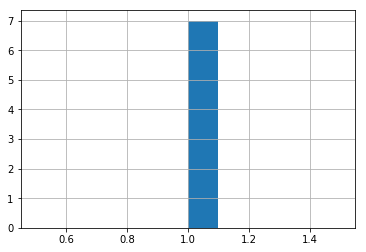

In [55]:
x_data_nosens_test[(x_data_nosens_test.attr <= 6.25) & (x_data_nosens_test.attr > 5.5) & (x_data_nosens_test.go_out > 5.5)].pred_dec.hist()

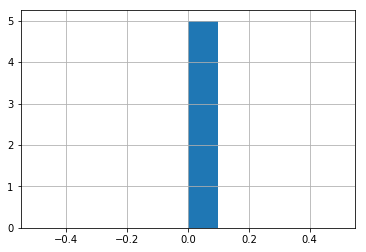

In [56]:
x_data_test[(x_data_test.attr <= 6.25) & (x_data_test.attr > 5.5) & (x_data_test.go_out > 5.5)].pred_dec.hist()

And indeed, the decision logic of the two models that respectively include and exclude the sensitive attributes results in conflicting predictions for these samples.

## 2 Patterns of discrimination

### 2.1 Is there still a bias towards gender?

###### Male decision tree
![title](male_decision_tree_sens.png)

###### Female decision tree
![title](female_decision_tree_sens.png)

###### Unisex decision tree
![title](unisex_decision_tree_sens.png)

We have two different attributes in our unisex model, race and attr (attractiveness of the partner). Clearly, race is not a gender-correlated attribute, because regardless of race, the division between male and female will be approximately 50%, if your dataset is large enough. 

To test whether attractiveness is gender-correlated, we will investigate the ratio of males to females for certain levels of attractiveness. We start by trying the left-most path, i.e. where attr <= 4.5.

In [57]:
male_subjects_L = male_subjects.drop(male_subjects[male_subjects.attr > 4.5].index)
female_subjects_L = female_subjects.drop(female_subjects[female_subjects.attr > 4.5].index)
print("Percentage of male subjects where attr <= 4.5: " + str(int(len(male_subjects_L)/len(male_subjects)*100)) + "%")
print("Percentage of female subjects where attr <= 4.5: " + str(int(len(female_subjects_L)/len(female_subjects)*100)) + "%")

Percentage of male subjects where attr <= 4.5: 13%
Percentage of female subjects where attr <= 4.5: 23%


Clearly there is a very large difference, there are almost twice as many females who rate the attractiveness of their partners lower than 4.5. This is likely because females are more critical when selecting their partners, or perhaps the males in the dataset are more desperate to find a partner. Regardless, this shows that attr is a gender-correlated attribute, because when the value for attr is low, the subject is more likely to be female. 

Now, for completeness, we will investigate the right-most path as well, to see if this rule also holds the other way around: Does a high value for attr mean that the subject is likely male?

In [58]:
male_subjects_R = male_subjects.drop(male_subjects[male_subjects.attr <= 8.25].index)
female_subjects_R = female_subjects.drop(female_subjects[female_subjects.attr <= 8.25].index)
print("Percentage of male subjects where attr > 8.25: " + str(int(len(male_subjects_R)/len(male_subjects)*100)) + "%")
print("Percentage of female subjects where attr > 8.25: " + str(int(len(female_subjects_R)/len(female_subjects)*100)) + "%")

Percentage of male subjects where attr > 8.25: 12%
Percentage of female subjects where attr > 8.25: 8%


So yes, the relation also holds the other way round. Subjects that have rated the attractiveness of their partner very high are more likely to be male. Thus, attr is certainly a gender-correlated attribute.

Now, let's look at some paths in the decision trees. One path worth looking at in the female decision tree, is the bottom left part. In the female model the path where the value of attractiveness is larger than 6.5 and smaller than 7.5, splits on the value race <= 2.5. The two resulting leaves of these splits don't say very much, i.e. they are not pure. In the unisex model, this path looks almost exactly the same. However, the male model splits on imprace instead of race. Therefore it might be worth investigating whether the unisex model discriminates on the female gender in this particular split in the unisex model. If the dec-values for males are affected similarly, then this would show that the model doesn't discriminate, and that this decision makes sense for both genders. For both male and female models, the correlation between gender and the attribute imprelig are computed.

To test whether race is a gender-correlated attribute, we will investigate the ratio of males to females where race > 2.5.

In [59]:
male_subjects0_R = male_subjects.drop(male_subjects[male_subjects.attr <= 6.25 ].index)
male_subjects0_R = male_subjects.drop(male_subjects[male_subjects.attr > 7.25 ].index)
male_subjects1_R = male_subjects0_R.drop(male_subjects0_R[male_subjects0_R.race > 2.5].index)
male_subjects2_R = male_subjects0_R.drop(male_subjects0_R[male_subjects0_R.race <= 2.5].index)

male_subjects2_R1 = male_subjects1_R.drop(male_subjects1_R[male_subjects1_R.dec == 0].index)
male_subjects2_R2 = male_subjects1_R.drop(male_subjects1_R[male_subjects1_R.dec == 1].index)
print("Male percentage dec=1 where race <= 2.5 : " + str(int(len(male_subjects2_R1) / (len(male_subjects2_R1) + len(male_subjects2_R2))*100)) + "%")

Male percentage dec=1 where race <= 2.5 : 32%


In [60]:
male_subjects2_R12 = male_subjects2_R.drop(male_subjects2_R[male_subjects2_R.dec == 0].index)
male_subjects2_R22 = male_subjects2_R.drop(male_subjects2_R[male_subjects2_R.dec == 1].index)
print("Male percentage dec=1 where race > 2.5 : " + str(int(len(male_subjects2_R12) / (len(male_subjects2_R12) + len(male_subjects2_R22))*100)) + "%")

Male percentage dec=1 where race > 2.5 : 41%


In [61]:
female_subjects0_R = female_subjects.drop(female_subjects[female_subjects.attr <= 6.25 ].index)
female_subjects0_R = female_subjects.drop(female_subjects[female_subjects.attr > 7.25 ].index)

female_subjects1_R = female_subjects0_R.drop(female_subjects0_R[female_subjects0_R.race > 2.5].index)
female_subjects2_R = female_subjects0_R.drop(female_subjects0_R[female_subjects0_R.race <= 2.5].index)

female_subjects2_R1 = female_subjects1_R.drop(female_subjects1_R[female_subjects1_R.dec == 0].index)
female_subjects2_R2 = female_subjects1_R.drop(female_subjects1_R[female_subjects1_R.dec == 1].index)
print("Female percentage dec=1 where race <= 2.5 : " + str(int(len(female_subjects2_R1) / (len(female_subjects2_R1) + len(female_subjects2_R2))*100))+"%")

Female percentage dec=1 where race <= 2.5 : 23%


In [62]:
female_subjects2_R12 = female_subjects2_R.drop(female_subjects2_R[female_subjects2_R.dec == 0].index)
female_subjects2_R22 = female_subjects2_R.drop(female_subjects2_R[female_subjects2_R.dec == 1].index)
print("Female percentage dec=1 where race > 3.5 : " + str(int(len(female_subjects2_R12) / (len(female_subjects2_R12) + len(female_subjects2_R22))*100))+"%")

Female percentage dec=1 where race > 3.5 : 33%


In [63]:
male_subjects_R = male_subjects.drop(male_subjects[male_subjects.race <= 2.5].index)
female_subjects_R = female_subjects.drop(female_subjects[female_subjects.race <= 2.5].index)

In [64]:
print("Percentage of male subjects where race > 2.5: " + str(int(len(male_subjects_R)/len(male_subjects)*100)) + "%")
print("Percentage of female subjects where race > 2.5: " + str(int(len(female_subjects_R)/len(female_subjects)*100)) + "%")

Percentage of male subjects where race > 2.5: 35%
Percentage of female subjects where race > 2.5: 41%


As these results show, there is no significant difference between these two ratios. So we see that ethnicity does not influence the decision whether the subject wants to see the partner again. Note that the race attribute only says something about the race of the subject, and not about the partner's race.

Data mining provides some powerfool tools for discovering discrimination in historical decision records. One of these is the classification rule mining. For classification rule mining, we consider a potentially distriminated (PD) group. A subset of attribute values are perceived as potentially discriminatory based on background knowledge. Potentially discriminated groups are people with those attribute values. These are the sensitive attributes that were chosen in the model at the beginning of this assignment. Direct discrimination occurs when decisions are made based on biased sensitive attributes. Associaton rules are if/ then statements that can help uncover relationships between, at first sight, unrelated data in a dataset. In a classification rule, $Y$ is a class item (in this case, `gender`) and $X$ contains no class items (in this case, the unisex model). This is denoted as follows: $X \rightarrow Y$. 

PD rules are any classification rule of the form: $A, B \rightarrow C$, where $A$ is the protected attribute (PD, the gender correlated attribute), $B$ is some context and $C$ is the attribute to predict (`dec`). It gets more complicated when you enter the area of indirect discrimination. 

Indirect discrimination occurs when decisions are made based on non-sensitive attributes which are strongly correlated with biased sensitive attributes. Potentially non-discriminatory (PND) rules may unveil discrimination, and are described as follows: $D,B \rightarrow C$, where $D$ is a PND group. For indirect discrimination, background knowledge is needed to allow us to infer discrimination in the model. Of course, this is all qualified according to what the confidence of these delivered rules are. The notion of extended lift is very important for measuring whether a group of people are treated "less favourably" than others. Extended lift is a measure of the increased confidence in concluding an assertion $C$ resulting from adding (potentially discriminatory) information $A$ to a rule $B \rightarrow C$ where no PD itemset appears. Recall that `conf`($X \rightarrow Y$) = $\frac{`support`(X \rightarrow Y)}{`support`(X)}$. Support determines how often a rule is applicable to a given data set, while confidence determines how frequently items in $Y$ appear, when also $X$ is contained. 

So, let $A, B \rightarrow C$ be a classification rule with `conf`($B \rightarrow C$ > 0). The extended lift of the rule is: $$ elift(A,B \rightarrow C) = \frac{conf(A,B \rightarrow C)}{conf(B \rightarrow C)} $$. So, for example, a rule `gender = female`, `race <= 2.5` $\rightarrow$ `dec = 0` with an extended lift of 3 means that being a female increases the probability of deciding not to see the partner again by 3-fold with respect to the average confidence of people who don't find it important that their partner is of the same race. So when the extended lift, or this ratio, is very high, then you can claim that males or females are discriminated against. So, you are trying to look for these rules where you have an increase in the confidence that is explicable only by the protected attributes that you were not supposed to see in the first place. 

The last thing that is important to know is the concept of $\alpha$-protection. For a given threshold $\alpha$, we say that PD rule $A,B \rightarrow C$, involving a PD group A in a context B for an outcome C is $\alpha$-protective if:
                                $$elift_B (A,B \rightarrow C) = \frac{conf(A,B \rightarrow C}{conf(B \rightarrow C)} \leq \alpha$$
Otherwise, we say that $A,B \rightarrow C$ is an $\alpha$-discriminatory rule. 

To mine the association rules from the dataframe `dates`, the dataframe is converted to a csv file. To construct these association rules, alle itemsets are mined with a minimum support of 0.50 and a minimum confidence of 0.70 in RapidMiner. The RapidMiner process that is used to mine the association rules looks as follows:

In [65]:
dates.to_csv('featured_attributes.csv')

![title](rapid_miner_setup.png)

First, all the attributes are selected from the dataset. For some association rules, we have to filter the attributes on some values, to measure the extended lift. After that all values in the columns are discretized, possible nominal values are converted to binominal values and the `FP-growth` operation calculates all frequent itemsets from the given dataset using the FP-tree data structure. It is compulsory that all attributes of the input dataset should be binominal. The `create Association rules`- operation generates a set of association rules from the given set of frequent itemsets.

![title](association_rules.png)
![title](race_dec_rule.png)

Recall that we are looking for association rules of the form $A, B \rightarrow C$, where $A$ is the gender correlated attribute, $B$ is some context and $C$ is the attribute to predict. From the analysis above, we have concluded that `attr` the only gender correlated attribute is in our model. $C$ is the value to be predicted, which is `dec` in our case. There are only two association rules where $C$ == 'dec'. The first one is `attr`, `race` $\rightarrow$ `dec`.  The conf($A,B \rightarrow C$)= 0.656 and conf($B \rightarrow C$) = 0.422. Therefore $elift(A,B \rightarrow C) = \frac{conf(A,B \rightarrow C)}{conf(B \rightarrow C)} = \frac{0.715}{0.465} = 1.54$.

The second rule( `gender`, `attr` $\rightarrow$ `dec`), has `gender` as the `gender correlated attribute`, which doesn't make sense at all. 

To claim that `attr`, `race` $\rightarrow$ `dec` is an $\alpha$-discriminatory rule, we have to set a value for $\alpha$. To make a strong claim that this rule is discriminatory, we set $\alpha = 2$. This means that we want to be twice as confident about the subgroup for this particular gender, than for all the other people. Because $1.55 < 2$, we can conclude that this association rule is not discriminatory. However, note that the context $B$ in this case contains all the races of the dataset. The elift could be increased by filtering some races out of the dataset. After experimenting with different race values, the highest elift was extracted when `race` = 2,3 or 4.

![title](race_rule_234.png)
![title](race_dec_rule.png)

$elift(attr,race \rightarrow dec) = \frac{conf(attr,race \rightarrow dec)}{conf(race \rightarrow dec)} = \frac{0.724}{0.456} = 1.60$. This means that this rule is 1.60 times as confident about the Latino/Hispanic/Asian and European Americans that the decision leads to see their partner again.
The extented lift has increased somewhat, but still it is not larger than the predefined threshold of $\alpha = 2$. Therefore , we can conclude that this rule is not discriminating. 

As can be seen from the figure above, there are two other association rules where $A = $`attr` and $C = $`dec`. The first one is `attr`, `go_out` $\rightarrow$ `dec`. The extended lift of this rule is calculated as follows: $elift(attr,go\_out \rightarrow dec) = \frac{conf(attr,go\_out \rightarrow dec)}{conf(go\_out \rightarrow dec)} = \frac{0.698}{0.465} = 1.50$. This means that this rule is 1.50 times as confident about the females, than for all the persons.
The last association rule is `attr`, `age_diff` $\rightarrow$ `dec`. In the first assignment we saw that the chance of `dec=1` gets higher when the age difference between the partner and the subject is small. Therefore, we set `age_diff`= 10.  

![title](age_diff_rule_10.png)
![title](agediff10_dec_rule.png)

As can be seen from the picture above, the confidence of this rule is 0.668. The extended lift of `attr`, `age_diff` $\rightarrow$`dec` is: 
$elift(attr, age\_{diff} \rightarrow dec) = \frac{conf(attr,age\_ {diff} \rightarrow dec)}{(attr,(age\_{diff} \rightarrow dec)} = \frac{0.668}{0.410} = 1.67$. This means that for the female correlated attribute attractiveness and when the age difference between the subject and the partner is, we are 1.67 times more confident that these females chose to see their partner again. However, comparing to $\alpha = 2$, this rule is not strong enough, and therefore not discriminating. 

Because `attr` was the only gender-correlated attribute in the model, there are no more association rules to discuss. The examples where the context is set to a specific value are chosen after different experiments with the values of that particular attribute. All the rules have an elift of approximately 1.50 or higher, which means that the model is slighty biased when it splits on the attractiveness attribute. This attribute is slightly gender-correlated, however, the relation is not very strong.

### 2.2 Biclustering

Biclustering algorithms simultaneously cluster rows and columns of a data matrix. These clusters of rows and columns are knows as biclusters. Each determines a submatrix of the original data matrix with some desired properties. 

In this paragraph we want to find interesting patterns and discriminations or biases that make a grop of subjects, with some coherent characterstics, prefer a specific group of partners, also with some specific characteristics. For Biclustering, the package `coclust` is used. First the values of the unisex model are scaled.

In [66]:
from sklearn import preprocessing
x = unisex.values
scaler = preprocessing.MinMaxScaler((0,7000))
X_scaled = scaler.fit_transform(x)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1000.000000,1400.0,0.0,7000.0,567.567568,0.0,4200.0,1400.0,2333.333333,4200.0,1312.50,0.0,7000.0
1,666.666667,1400.0,0.0,7000.0,567.567568,0.0,4900.0,1400.0,2333.333333,4200.0,218.75,0.0,7000.0
2,3000.000000,1400.0,0.0,7000.0,567.567568,0.0,3500.0,1400.0,2333.333333,4200.0,218.75,7000.0,7000.0
3,1333.333333,1400.0,0.0,7000.0,567.567568,0.0,4900.0,1400.0,2333.333333,4200.0,437.50,7000.0,7000.0
4,2000.000000,1400.0,0.0,7000.0,567.567568,0.0,3500.0,1400.0,2333.333333,4200.0,656.25,0.0,7000.0


In [67]:
import matplotlib.pyplot as plt
import numpy as np, scipy.sparse as sp, scipy.io as io
from sklearn.metrics import confusion_matrix

from coclust.coclustering import (CoclustMod, CoclustSpecMod, CoclustInfo)
from coclust.evaluation.external import accuracy
from coclust.visualization import plot_reorganized_matrix

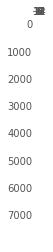

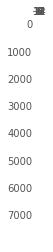

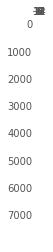

In [68]:
X = X_scaled.as_matrix()
model_1 = CoclustMod(n_clusters=4, n_init=4)
model_1.fit(X)
model_2 = CoclustSpecMod(n_clusters=4, n_init=4)
model_2.fit(X)

model_3 = CoclustInfo(n_row_clusters=3, n_col_clusters=4, n_init=4)
model_3.fit(X)

plot_reorganized_matrix(X, model_1)

plot_reorganized_matrix(X, model_2)

plot_reorganized_matrix(X, model_3)


This is the best try we could make. We tried also the `biclustering` from the `scikitlearn` package, but that gives the same result. Biclustering is not mentioned in the slides, and the explanation oin the assignment is vague and short. The clusters can't be read well, despite the scaling we applied to it. 

##### Peer review

During our work on this assignment, all four group members have tried their best to contribute equally to the completion of the assignment. Naturally though, some group members are more experienced with the programming language that we chose, Python. Furthermore, some group members also have more experience with similar assignments about similar data-sets and their analysis. Therefore, they were able to use their time more efficiently, working on the assignment instead of researching how Python works, for instance. 

However, since all group members have worked hard on the assignment and have shown that they wanted to contribute all that they could, we do not feel that these differences should be reflected in grading. We think that every member of our group deserves to get the same grade for their contribution.